In [ ]:
from urllib.request import urlopen
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
import re
import os
import requests 
import json
import pandas as pd
from networkx.algorithms.community import greedy_modularity_communities

### 1. Retrieve all character names from the character summary page

In [2]:
raw_response=urlopen("https://onepiece.fandom.com/wiki/List_of_Canon_Characters")
response=raw_response.read()

In [3]:
# Parse the HTML response using BeautifulSoup with the "html.parser" parser.
soup = BeautifulSoup(response, "html.parser")

# Find the table with the class "fandom-table sortable" in the parsed HTML.
table = soup.find("table", class_="fandom-table sortable")

# Proceed if the table is found.
if table:
    # Locate the table body (tbody) within the table.
    tbody = table.find("tbody")
    # Extract all rows (tr) from the table body.
    rows = tbody.find_all("tr")
    
    # Initialize an empty dictionary to store character names and their links.
    names = {}
    
    # Iterate through each row in the table.
    for row in rows:
        # Find all columns (td) in the current row.
        cols = row.find_all("td")
        
        # Check if the row has more than one column (to skip empty or irrelevant rows).
        if len(cols) > 1:
            # Look for a link (a) inside the second column (character name column).
            name_link = cols[1].find("a")
            
            # If a link is found, extract the character name and its hyperlink.
            if name_link:
                names[name_link.text] = name_link.get("href")  # Store the name as the key and the link as the value.


In [ ]:
# List of standard arc names from a series, ensuring each name is unique and clearly defined.
standard_arc_names = [
    "Amazon Lily Arc", "Arabasta Arc", "Arlong Park Arc", "Baratie Arc", "Dressrosa Arc", 
    "Drum Island Arc", "Egghead Arc", "Elbaph Arc", "Enies Lobby Arc", "Fish-Man Island Arc",
    "Impel Down Arc", "Jaya Arc", "Levely Arc", "Little Garden Arc", "Loguetown Arc", 
    "Long Ring Long Land Arc", "Marineford Arc", "Orange Town Arc", "Post-Enies Lobby Arc", 
    "Post-War Arc", "Punk Hazard Arc", "Return to Sabaody Arc", "Reverse Mountain Arc", 
    "Romance Dawn Arc", "Sabaody Archipelago Arc", "Skypiea Arc", "Syrup Village Arc", 
    "Thriller Bark Arc", "Wano Country Arc", "Water 7 Arc", "Whisky Peak Arc", "Whole Cake Island Arc", "Zou Arc"
]

# Remove duplicates from the arc names list and sort them alphabetically.
unique_arcs = sorted(set(standard_arc_names))

with open("./filtered_summary.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

filtered_people = {name: link for name, link in names.items() if name in json_data}

# Create a dictionary mapping unique numerical IDs to arc names, starting from 1.
arc_dict = {i + 1: arc for i, arc in enumerate(unique_arcs)}

### 2. Capture all arcs and their corresponding content from all character interfaces, and build the network corresponding to each arc

In [ ]:
# Initialize the dictionary of characters
person_dict = filtered_people 

# Generate possible name variants (e.g., first name, last name) for each character
def generate_name_variants(person_dict):
    name_variants = {}
    for full_name in person_dict.keys():
        parts = full_name.split()  
        name_variants[full_name] = parts  
    return name_variants

name_variants = generate_name_variants(person_dict)

# Define the folder containing HTML files
html_folder = "../onepiece"

# Locate the specific <h2> tag whose child <span> contains "History"
def find_history_section(soup):
    for h2_tag in soup.find_all("h2"):  
        span = h2_tag.find("span", class_="mw-headline")  
        if span and span.text.strip() == "History":  
            return h2_tag  
    return None 

# Prepare a dictionary to store arc relationship graphs
arc_graph_map = {}
arc_pattern = re.compile(r".*Arc$")  

# Create a regular expression pattern for a full name (to avoid incorrect matches of middle parts)
def create_full_name_pattern(full_name):
    return re.compile(rf'\b{re.escape(full_name)}\b', re.IGNORECASE)

# Create regular expression patterns for name variants
def create_name_variant_patterns(variants):
    return [re.compile(rf'\b{re.escape(variant)}\b', re.IGNORECASE) for variant in variants]

empty_person = [] 

# Iterate through the HTML files
for html_file in os.listdir(html_folder):
    if html_file.endswith(".txt"): 
        person_name = os.path.splitext(html_file)[0]  
        file_path = os.path.join(html_folder, html_file)
        if person_name not in person_dict:
            continue
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()  
        
        # Parse the HTML content
        soup = BeautifulSoup(content, "html.parser")
        history_section = find_history_section(soup)

        if not history_section:  
            #print(f"No 'History' section for {person_name}")
            empty_person.append(person_name)
            continue

        # Get content from the "History" section until the next <h2>
        current = history_section.find_next_sibling()
        history_content = []

        while current:
            if current.name == "h2":  
                break
            history_content.append(current)
            current = current.find_next_sibling()

        # Track which names have been processed (to determine first appearances)
        processed_names = set() 

        # Track fully matched full names
        matched_full_names = set()  

        for element in history_content:
            if element.name in ["h3", "h4"]:  
                headline = element.find("span", class_="mw-headline")
                if headline and arc_pattern.match(headline.text): 
                    current_arc = headline.text.strip()

                    # Initialize a graph for the arc if not already present
                    if current_arc not in arc_graph_map:
                        arc_graph_map[current_arc] = nx.Graph()

                    # Extract the arc content
                    arc_content = []
                    sibling = element.find_next_sibling()

                    while sibling and not (sibling.name in ["h3", "h4", "h2"] and sibling.find("span", class_="mw-headline")):
                        arc_content.append(sibling.text if sibling else "")
                        sibling = sibling.find_next_sibling()

                    # Join the content of the arc into a single string
                    arc_text = " ".join(arc_content)

                    # Find all links in the HTML
                    all_links = soup.find_all("a", href=True)
                    link_names = {link.get_text().strip() for link in all_links}

                    for full_name, variants in name_variants.items():
                        full_name_pattern = create_full_name_pattern(full_name)

                        # Skip the person if their full name has not been processed and no link is found
                        if full_name not in processed_names:
                            if full_name in link_names:  
                                processed_names.add(full_name)
                            else:
                                continue

                        # Strict full name match
                        if full_name_pattern.search(arc_text) and full_name != person_name and full_name in person_dict:
                            matched_full_names.add(full_name)  
                            arc_graph_map[current_arc].add_edge(person_name, full_name)

                        # Match name variants if the full name has already been matched
                        elif full_name in matched_full_names:
                            for variant in variants:
                                variant_pattern = create_name_variant_patterns([variant])[0]
                                if variant_pattern.search(arc_text) and full_name != person_name:
                                    arc_graph_map[current_arc].add_edge(person_name, full_name)
                                    break

### 3.Capture the arc information that is not present on the homepage and obtain it from its corresponding subpage, and construct a network of arcs

In [ ]:
# Prepare to store new arc relationship graphs
arc_pattern = re.compile(r".*Arc$")  
sage_pattern = re.compile(r".*Saga$")  

name_variants = generate_name_variants(names)  

# Set to store names that have been processed to avoid duplication
processed_names = set()

# Function to check if a text represents a person's name, considering links and first-time occurrences
def is_person_name(text, link_tag):
    # If it's the first occurrence and no link is found, it's not considered a name
    if text not in processed_names:
        processed_names.add(text)
        if not link_tag:
            return False
    return True


# Loop through the names that are not found previously (empty_person)
for person_name in empty_person:
    #print(person_name)
    if person_name not in names:
        #print(f"URL for {person_name} not found in names dictionary.")
        continue

    # Get the new URL for the person's history section
    original_url = names[person_name]
    history_url = f"https://onepiece.fandom.com{original_url}/History"

    try:
        # Make a request to fetch the page content
        response = requests.get(history_url)
        response.raise_for_status()  # Check if the request was successful
        soup = BeautifulSoup(response.text, "html.parser")

        # Find all h2 tags, and filter those with titles ending in "Saga"
        h2_tags = soup.find_all("h2")
        sage_h2s = [h2 for h2 in h2_tags if h2.find("span", class_="mw-headline") and sage_pattern.match(h2.find("span", class_="mw-headline").text.strip())]

        # Skip if no matching "Saga" section is found
        if not sage_h2s:
            #print(f"No 'Saga' section found for {person_name} at {history_url}.")
            continue
        
        # Iterate through the found "Saga" titles
        for arc_start in sage_h2s:

            current = arc_start.find_next_sibling()
            in_arc_section = True  

            while current:
                if current.name == "h2":  # When a new h2 title is encountered
                    next_span = current.find("span", class_="mw-headline")
                    if next_span and not sage_pattern.match(next_span.text.strip()):
                        in_arc_section = False  # Leave the "Arc" section
                        break

                elif current.name == "h3" and in_arc_section:  # Check if it's an "Arc" title
                    headline = current.find("span", class_="mw-headline")
                    if headline and arc_pattern.match(headline.text.strip()):
                        current_arc = headline.text.strip()

                        # Initialize the graph for the current arc if it doesn't exist
                        if current_arc not in arc_graph_map:
                            arc_graph_map[current_arc] = nx.Graph()

                        # Extract the content of the arc
                        arc_text = []
                        sibling = current.find_next_sibling()
                        
                        # Iterate through content until the next "Saga" or "Arc" title is found
                        while sibling and not (
                            (sibling.name == "h2" and sibling.find("span", class_="mw-headline") and sage_pattern.match(
                                sibling.find("span", class_="mw-headline").text.strip()))  # New 'Saga' section found
                            or (sibling.name == "h3" and sibling.find("span", class_="mw-headline") and arc_pattern.match(
                                sibling.find("span", class_="mw-headline").text.strip()))  # New "Arc" section found
                            or (sibling.name == "h2" and sibling.find("span", class_="mw-headline") and not sage_pattern.match(
                                sibling.find("span", class_="mw-headline").text.strip()))  # Non-"Saga" h2 title found
                        ):
                            arc_text.append(sibling.text if sibling else "")
                            sibling = sibling.find_next_sibling()

                        # Join arc content into a single string
                        arc_text = " ".join(arc_text)

                        # Find all links and extract their names
                        all_links = soup.find_all("a", href=True)
                        link_names = {link.get_text().strip() for link in all_links}

                        # Find all matching person names
                        matched_full_names = set()  # Track fully matched names

                        for full_name, variants in name_variants.items():
                            full_name_pattern = create_full_name_pattern(full_name)

                            # Skip if the person's name is first encountered without a link
                            if full_name not in processed_names:
                                if full_name in link_names: 
                                    processed_names.add(full_name)
                                else:
                                    continue

                            # Strict full name match
                            if full_name_pattern.search(arc_text) and full_name != person_name and full_name in names:
                                matched_full_names.add(full_name)  
                                arc_graph_map[current_arc].add_edge(person_name, full_name)

                            # Match variants only if the full name has already matched
                            elif full_name in matched_full_names:
                                for variant in variants:
                                    variant_pattern = create_name_variant_patterns([variant])[0]
                                    if variant_pattern.search(arc_text) and full_name != person_name:
                                        arc_graph_map[current_arc].add_edge(person_name, full_name)
                                        break

                current = current.find_next_sibling()

    except requests.RequestException as e:
        print(f"Failed to fetch {history_url} for {person_name}: {e}")


### 4.Merge identical circular arc networks with inconsistent names on the personal homepage

In [ ]:
# Create a dictionary mapping normalized names to the standard names
normalized_name_map = {name.replace(" ", "").replace("-", "").lower(): name for name in standard_arc_names}

# Function to normalize arc names (remove spaces and hyphens, and convert to lowercase)
def normalize_arc_name(name):
    return name.replace(" ", "").replace("-", "").lower()

# Merge similar arc graphs based on the normalized arc names
def merge_similar_arcs(arc_graph_map, normalized_name_map):
    to_delete = []  # List to store arcs that need to be deleted
    merged_graphs = {}  # Dictionary to store merged arc graphs

    for arc_name in arc_graph_map:
        # Normalize the arc name
        normalized_name = normalize_arc_name(arc_name)

        # Find the reference name corresponding to the normalized name
        reference_name = normalized_name_map.get(normalized_name, None)

        if reference_name:
            # If the normalized name matches a standard name, merge the graph
            if reference_name in merged_graphs:
                # Merge the current graph into the existing graph
                merged_graphs[reference_name] = nx.compose(merged_graphs[reference_name], arc_graph_map[arc_name])
                to_delete.append(arc_name)
            else:
                # If it's the first time encountering the standard name, add the graph
                merged_graphs[reference_name] = arc_graph_map[arc_name]
        else:
            # If no match is found for the standard name, delete the arc graph
            to_delete.append(arc_name)

    # Delete the unnecessary arc graphs
    for arc_name in to_delete:
        del arc_graph_map[arc_name]

    # Add the merged graphs to the arc_graph_map
    arc_graph_map.update(merged_graphs)

# Call the function to merge similar arcs
merge_similar_arcs(arc_graph_map, normalized_name_map)

# Print the merged results
for arc_name, graph in arc_graph_map.items():
    print(f"{arc_name} with {len(graph.nodes)} nodes and {len(graph.edges)} edges")


Marineford Arc with 112 nodes and 411 edges
Post-War Arc with 118 nodes and 193 edges
Zou Arc with 108 nodes and 343 edges
Dressrosa Arc with 149 nodes and 1040 edges
Thriller Bark Arc with 61 nodes and 265 edges
Wano Country Arc with 274 nodes and 1600 edges
Skypiea Arc with 53 nodes and 208 edges
Egghead Arc with 240 nodes and 729 edges
Whole Cake Island Arc with 114 nodes and 685 edges
Romance Dawn Arc with 21 nodes and 43 edges
Loguetown Arc with 42 nodes and 95 edges
Jaya Arc with 61 nodes and 167 edges
Amazon Lily Arc with 38 nodes and 67 edges
Impel Down Arc with 58 nodes and 183 edges
Return to Sabaody Arc with 32 nodes and 74 edges
Levely Arc with 99 nodes and 268 edges
Arlong Park Arc with 33 nodes and 142 edges
Elbaph Arc with 37 nodes and 53 edges
Arabasta Arc with 55 nodes and 246 edges
Punk Hazard Arc with 52 nodes and 150 edges
Sabaody Archipelago Arc with 79 nodes and 308 edges
Long Ring Long Land Arc with 33 nodes and 83 edges
Post-Enies Lobby Arc with 82 nodes and 144

### 5.Save all network structures as JSON files

In [ ]:
# Iterate through each arc and its corresponding graph in the arc_graph_map.
for arc, graph in arc_graph_map.items():
    # Identify self-loops in the graph and remove them.
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)

# Initialize dictionaries to store relationships between arcs, characters, and graph structures.
arc_to_characters = {}  # Maps each arc to the characters (nodes) it contains.
character_to_arcs = {}  # Maps each character to the arcs it appears in.
arc_graph_structures = {}  # Maps each arc to its graph's adjacency list structure.

# Iterate through each arc and its corresponding graph again.
for arc, graph in arc_graph_map.items():
    # Extract the characters (nodes) from the graph.
    characters = list(graph.nodes())
    arc_to_characters[arc] = characters

    # Create an adjacency list representing the graph's structure.
    adjacency_list = {node: list(graph.neighbors(node)) for node in graph.nodes()}
    arc_graph_structures[arc] = adjacency_list

    # Map each character to the arcs they are part of.
    for character in characters:
        if character not in character_to_arcs:
            character_to_arcs[character] = []
        character_to_arcs[character].append(arc)

# Define the output folder path.
output_folder = "output"

# Create the output folder if it doesn't already exist.
os.makedirs(output_folder, exist_ok=True)

# Save the arc-to-characters mapping as a JSON file.
with open(os.path.join(output_folder, "arc_to_characters.json"), "w", encoding="utf-8") as f:
    json.dump(arc_to_characters, f, ensure_ascii=False, indent=4)

# Save the character-to-arcs mapping as a JSON file.
with open(os.path.join(output_folder, "character_to_arcs.json"), "w", encoding="utf-8") as f:
    json.dump(character_to_arcs, f, ensure_ascii=False, indent=4)

# Save the arc graph structures (adjacency lists) as a JSON file.
with open(os.path.join(output_folder, "arc_graph_structures.json"), "w", encoding="utf-8") as f:
    json.dump(arc_graph_structures, f, ensure_ascii=False, indent=4)

# Notify the user that the JSON files have been saved.
print(f"JSON files saved to {output_folder}/")

### 6.Analyzing arc networks using centrality and betweenness centrality

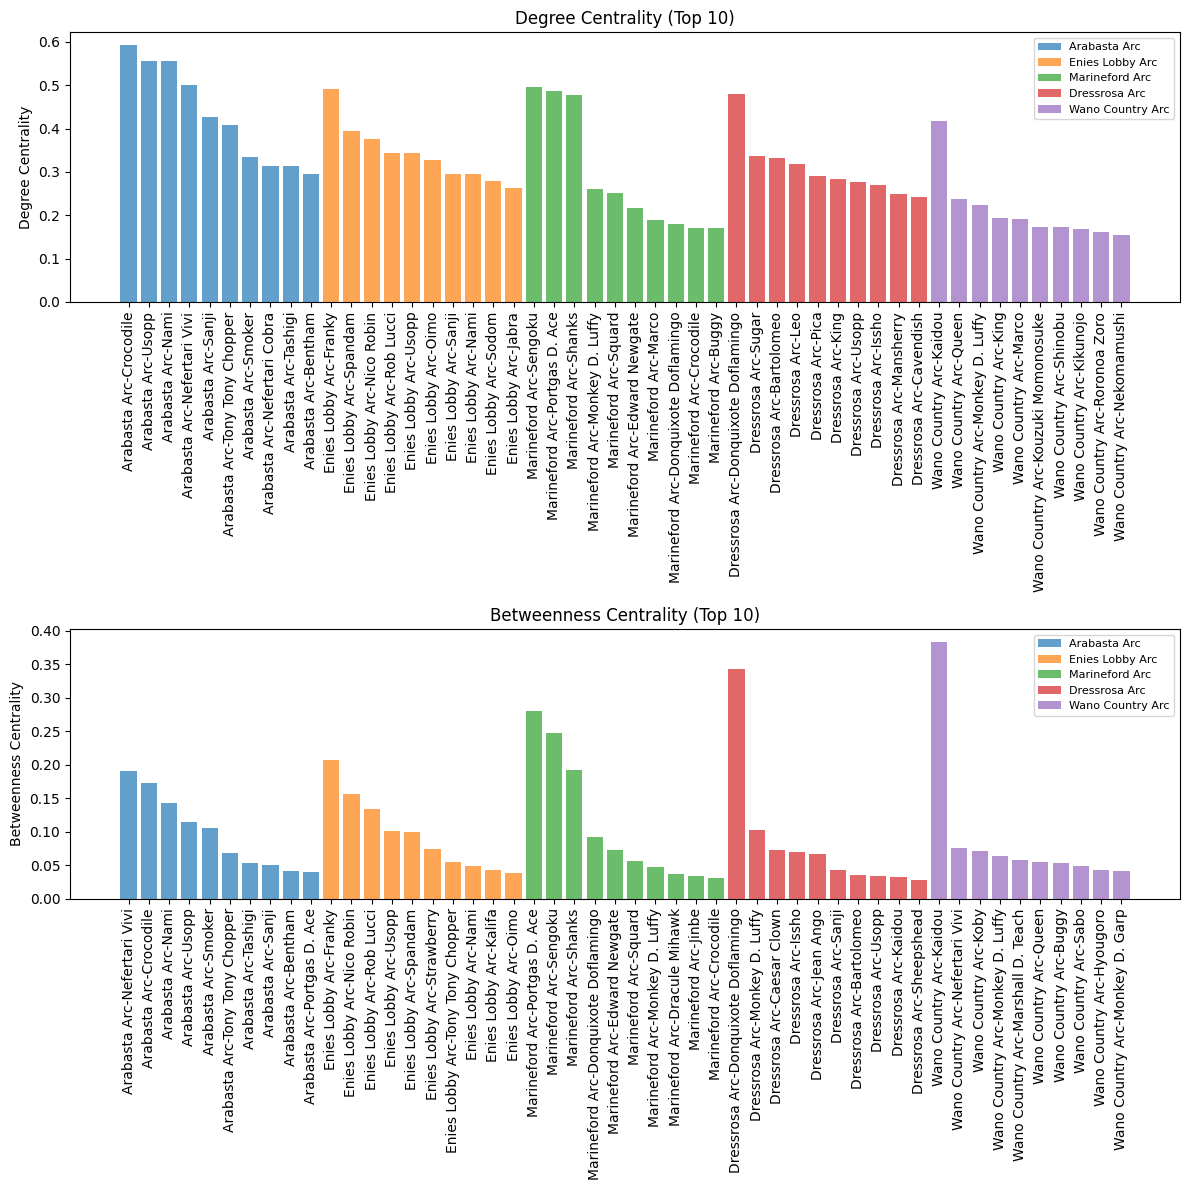

In [ ]:
# Define the order of arcs
arc_order = [
    "Arabasta Arc", "Enies Lobby Arc", "Marineford Arc", "Dressrosa Arc", "Wano Country Arc"
]

# Initialize results
centrality_data = []

# Compute centralities for selected arcs
for arc_name in arc_order:
    graph = arc_graph_map[arc_name]
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)

    # Store top nodes for each centrality metric
    for metric_name, metric in [
        ("Degree Centrality", degree_centrality),
        ("Betweenness Centrality", betweenness_centrality),
        ("Eigenvector Centrality", eigenvector_centrality),
    ]:
        top_nodes = sorted(metric, key=metric.get, reverse=True)[:10]
        for node in top_nodes:
            centrality_data.append({
                "Arc": arc_name,
                "Node": node,
                "Metric": metric_name,
                "Value": metric[node],
            })

# Create a DataFrame for visualization
centrality_df = pd.DataFrame(centrality_data)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
metrics = ["Degree Centrality", "Betweenness Centrality"]
titles = ["Degree Centrality (Top 10)", "Betweenness Centrality (Top 10)"]

for i, metric in enumerate(metrics):
    metric_data = centrality_df[centrality_df["Metric"] == metric]
    for arc_name in arc_order:
        arc_data = metric_data[metric_data["Arc"] == arc_name]
        axes[i].bar(
            [f"{arc_name[:20]}-{node}" for node in arc_data["Node"]],
            arc_data["Value"],
            label=arc_name,
            alpha=0.7
        )
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(metric)
    axes[i].legend(loc='upper right', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### 7.Visualizing data based on the arc graph structure of the storyline

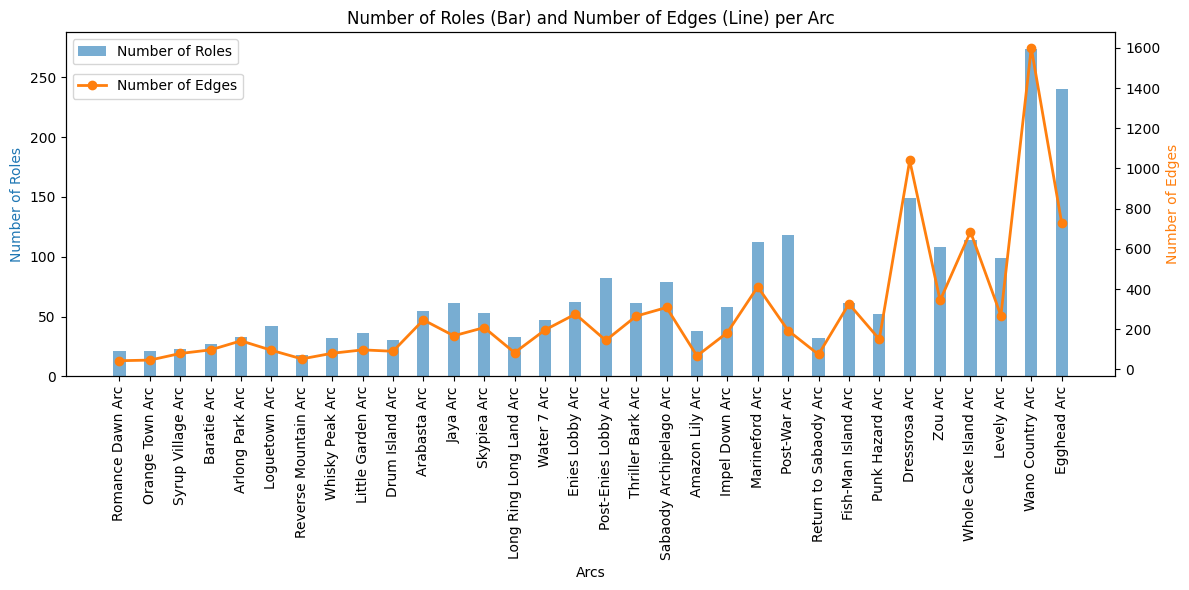

In [10]:
# Define the order of arcs
arc_order = [
    "Romance Dawn Arc", "Orange Town Arc", "Syrup Village Arc", "Baratie Arc", "Arlong Park Arc",
    "Loguetown Arc", "Reverse Mountain Arc", "Whisky Peak Arc", "Little Garden Arc", "Drum Island Arc",
    "Arabasta Arc", "Jaya Arc", "Skypiea Arc", "Long Ring Long Land Arc", "Water 7 Arc", "Enies Lobby Arc",
    "Post-Enies Lobby Arc", "Thriller Bark Arc", "Sabaody Archipelago Arc", "Amazon Lily Arc", "Impel Down Arc",
    "Marineford Arc", "Post-War Arc", "Return to Sabaody Arc", "Fish-Man Island Arc", "Punk Hazard Arc",
    "Dressrosa Arc", "Zou Arc", "Whole Cake Island Arc", "Levely Arc", "Wano Country Arc", "Egghead Arc"
]

# Initialize lists to store the number of nodes (roles) and edges for each arc
nodes_count = []
edges_count = []

# Collect data for each arc
for arc_name in arc_order:
    graph = arc_graph_map[arc_name]
    nodes_count.append(len(graph.nodes))
    edges_count.append(len(graph.edges))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar chart for number of nodes (roles)
ax1.bar(arc_order, nodes_count, color='#1f77b4', alpha=0.6, label='Number of Roles', width=0.4, align='center')
ax1.set_xlabel('Arcs')
ax1.set_ylabel('Number of Roles', color='#1f77b4')
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Number of Roles (Bar) and Number of Edges (Line) per Arc')

# Create a second axis to plot the line chart for number of edges
ax2 = ax1.twinx()
ax2.plot(arc_order, edges_count, color='#ff7f0e', marker='o', label='Number of Edges', linewidth=2)
ax2.set_ylabel('Number of Edges', color='#ff7f0e')

# Add legends to the left upper corner
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10)
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9), fontsize=10)

# Tight layout to prevent label overlap
plt.tight_layout()

# Save the figure
plt.savefig('arc_roles_and_edges_colored_legend_left.png')

# Show the plot
plt.show()